<a target="_blank" href="https://colab.research.google.com/github/sakarimov/Basic-ML-Model/blob/main/JanKenPon%20CNN%20Image%20Recognizer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Student Name** : Sulthan A. Karimov
# **Username** : sulthankarimov
# **Email** : sulthankarimov@gmail.com

In [6]:
!pip install split-folders[full] matplotlib jupyter_http_over_ws imutils

In [7]:
# import all needed libraries
import zipfile, os, shutil, splitfolders, re, random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report


In [8]:
# defining directories
local_dir = '/tmp/'
dataset_name = 'rockpaperscissors'
local_data = local_dir + dataset_name
local_zip = local_data + '.zip'

In [9]:
# dowload dataset (pass if exist)
!test -f $local_zip || wget --no-check-certificate \
 https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
 -O $local_zip

In [10]:
# extract dataset
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(local_dir)
zip_ref.close()

In [11]:
# prepare train & validation split
shutil.rmtree(local_data + '/rps-cv-images')
os.remove(local_data + '/README_rpc-cv-images.txt')
print(os.listdir(local_data))

base_dir = local_dir + '/rps'
if os.path.exists(base_dir) == True:
  shutil.rmtree(base_dir)

splitfolders.ratio(local_data, base_dir, ratio=(.6,.4))
train_dir = os.path.join(base_dir, 'train')
print('amount of training sample : ', sum(len(files) for _, _, files in os.walk(re.escape(base_dir) + r'/train')))
validation_dir = os.path.join(base_dir, 'val')
print('amount of validation sample : ', sum(len(files) for _, _, files in os.walk(re.escape(base_dir) + r'/val')))

['rock', 'scissors', 'paper']


Copying files: 2188 files [00:01, 2052.05 files/s]

amount of training sample :  1312
amount of validation sample :  876


In [12]:
# prepare test folder for classification report
files_list = []

for root, dirs, files in os.walk(local_data):
  for dir in dirs:
    results = os.walk(local_data + '/' + dir)
    for result in results:
      cat_list = []
      for file in result[2]:
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
          cat_list.append(os.path.join(root + '/' + dir, file))
    files_list.append(cat_list)

for imgs in files_list:
  category = re.findall('(?<=rs\/).*?(?=\/)', imgs[0])[0]
  filesToCopy = random.sample(imgs, 4)
  destPath = base_dir + '/test/' + str(category)
  if os.path.isdir(destPath) == False:
    os.makedirs(destPath)
  for file in filesToCopy:
    shutil.copy(file, destPath)

test_dir = os.path.join(base_dir, 'test')

In [13]:
# directory summary
print(os.listdir(train_dir))
print(os.listdir(validation_dir))
print(os.listdir(test_dir))

['rock', 'scissors', 'paper']
['rock', 'scissors', 'paper']
['rock', 'scissors', 'paper']


In [14]:
# preparing generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    preprocessing_function = preprocess_input,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

In [15]:
# defining rgb mean for every generator
mean = np.array([123.68, 116.779, 103.939], dtype = 'float32')
train_datagen.mean = mean
test_datagen.mean = mean

In [16]:
# flow data to generator
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
)

totalTrain = len(list(paths.list_images(train_dir)))
totalVal = len(list(paths.list_images(validation_dir)))
totalTest = len(list(paths.list_images(test_dir)))

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [17]:
# preparing baseModel
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

58889256/58889256 [==============================] - 0s 0us/step


In [18]:
# freeze hidden layers to preserve model features
for layer in baseModel.layers:
    layer.trainable = False

In [19]:
# prepare callbacks
EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    patience = 4,
    verbose = 1,
    restore_best_weights = True,
    min_delta = 0.1
)

ModelCP = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 1,
    verbose = 1
)

callbacks = [EarlyStop, ModelCP]

In [20]:
# compile the model with frozen layers
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit(
	x=train_generator,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=validation_generator,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=25,
    callbacks=callbacks,
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
41/41 [==============================] - 38s 606ms/step - loss: 1.6104 - accuracy: 0.3948 - val_loss: 1.1712 - val_accuracy: 0.3299 - lr: 1.0000e-04
Epoch 2/25
41/41 [==============================] - 24s 587ms/step - loss: 1.1336 - accuracy: 0.4223 - val_loss: 0.9012 - val_accuracy: 0.5764 - lr: 1.0000e-04
Epoch 3/25
41/41 [==============================] - ETA: 0s - loss: 0.9340 - accuracy: 0.5777
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
41/41 [==============================] - 22s 532ms/step - loss: 0.9340 - accuracy: 0.5777 - val_loss: 1.0275 - val_accuracy: 0.3738 - lr: 1.0000e-04
Epoch 4/25
41/41 [==============================] - 24s 596ms/step - loss: 0.8847 - accuracy: 0.5998 - val_loss: 0.7451 - val_accuracy: 0.7083 - lr: 5.0000e-05
Epoch 5/25
41/41 [==============================] - 22s 541ms/step - loss: 0.7422 - accuracy: 0.7919 - val_loss: 0.6416 - val_accuracy: 0.9375 - lr: 5.

In [21]:
# create classification_report for trained model
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
predIdxs = model.predict(x=test_generator,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs,
	target_names=test_generator.class_indices.keys()))

[INFO] evaluating after fine-tuning network head...
1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00         4
        rock       1.00      1.00      1.00         4
    scissors       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [22]:
# recreate model with unfrozen layers
clear_session()
train_generator.reset()
validation_generator.reset()
for layer in baseModel.layers[15:]:
	layer.trainable = True

In [23]:
# recompile and retrain the model after unfreezing layers
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
H = model.fit(
	x=train_generator,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=validation_generator,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=20,
    callbacks=callbacks,
)

[INFO] re-compiling model...
Epoch 1/20
41/41 [==============================] - 26s 562ms/step - loss: 0.5498 - accuracy: 0.8255 - val_loss: 0.5427 - val_accuracy: 0.7882 - lr: 1.0000e-04
Epoch 2/20
41/41 [==============================] - 22s 535ms/step - loss: 0.3568 - accuracy: 0.9093 - val_loss: 0.2297 - val_accuracy: 0.9525 - lr: 1.0000e-04
Epoch 3/20
41/41 [==============================] - 21s 514ms/step - loss: 0.2275 - accuracy: 0.9459 - val_loss: 0.1615 - val_accuracy: 0.9618 - lr: 1.0000e-04
Epoch 4/20
41/41 [==============================] - 23s 557ms/step - loss: 0.1356 - accuracy: 0.9688 - val_loss: 0.1183 - val_accuracy: 0.9711 - lr: 1.0000e-04
Epoch 5/20
41/41 [==============================] - 24s 571ms/step - loss: 0.1202 - accuracy: 0.9726 - val_loss: 0.1065 - val_accuracy: 0.9803 - lr: 1.0000e-04
Epoch 6/20
41/41 [==============================] - 24s 576ms/step - loss: 0.1012 - accuracy: 0.9771 - val_loss: 0.0918 - val_accuracy: 0.9838 - lr: 1.0000e-04
Epoch 7/20


In [24]:
# create classification_report for full model
print("[INFO] evaluating after fine-tuning network...")
test_generator.reset()
predIdxs = model.predict(x=test_generator,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs,
	target_names=test_generator.class_indices.keys()))

[INFO] evaluating after fine-tuning network...
1/1 [==============================] - 0s 188ms/step
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00         4
        rock       1.00      1.00      1.00         4
    scissors       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



1/1 [==============================] - 0s 17ms/step


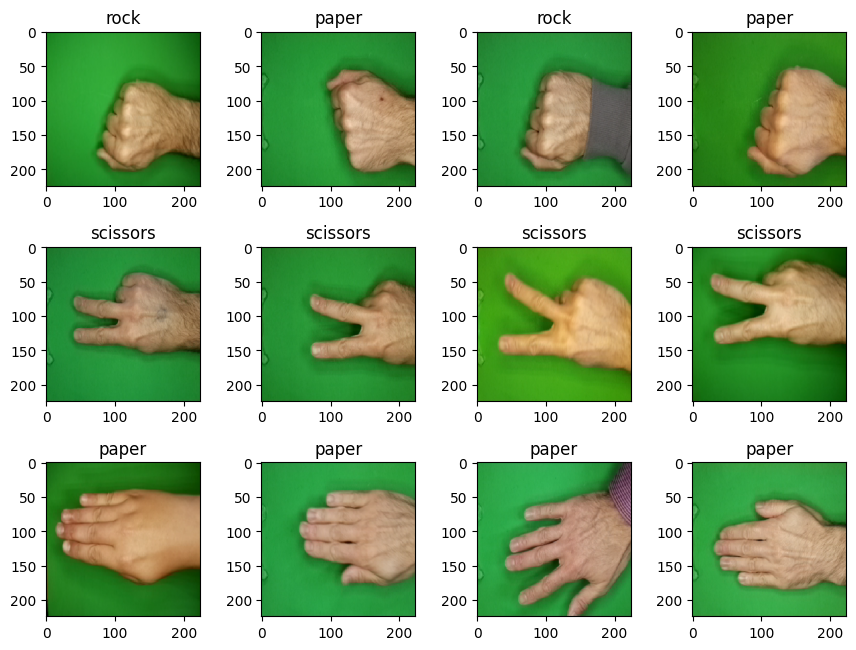

In [25]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

testdir = test_dir
uploaded = list(paths.list_images(testdir))
fig = plt.figure(figsize= (10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(len(uploaded)):
    path = uploaded[i]
    img = image.load_img(path, target_size = (224,224))

    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(img)
    images = image.img_to_array(img)
    images = np.expand_dims(images, axis=0)
    images = preprocess_input(images)
    pred = model.predict(images)
    ax.title.set_text(list(train_generator.class_indices.keys())[np.argmax(pred, axis = 1)[0]])
